### Resampling

zmiana czestotliowsci pomiarow dokonanych aparatura medyczna, aby moc przejrzyscie porowynywac wyniki z danymi z garmina
- dane z aparatury medycznej zapisane byly z czestotliwoscia 500hz
- dane z garmina mierzone byly z czestotliwoscia 128hz

W celu dokonania resamplingu wykorzystana zostala biblioteka scipy.

In [58]:
import os
import pandas as pd
from pathlib import Path

# Automatycznie znajduje plik bez względu na katalog roboczy
current_dir = Path.cwd()
project_root = current_dir if current_dir.name == "Projekt-EKG" else current_dir / "Projekt-EKG"

plik = project_root / "data" / "N38" / "N38_2025-2025-11-14-11-18-06.csv"

# Sprawdzenie czy plik istnieje
if plik.exists():
    print(f"Plik znaleziony: {plik}")
else:
    print(f"Błąd: Plik nie znaleziony: {plik}")
    print(f"Dostępne pliki w {project_root / 'data'}:")
    if (project_root / "data").exists():
        for item in (project_root / "data").rglob("*.csv"):
            print(f"  - {item}")

df = pd.read_csv(str(plik))


Plik znaleziony: /Users/janmichorek/Documents/ProgrammingProjects/HeartAnalisisProject/Projekt-EKG1/Projekt-EKG/data/N38/N38_2025-2025-11-14-11-18-06.csv


In [59]:
from scipy.signal import resample, butter, filtfilt, freqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



garmin_frequency = 128
medical_frequency = 500

number_of_new_samples = int(len(df) * (garmin_frequency/medical_frequency))

resampled_data = resample(df, number_of_new_samples)

resampled_df = pd.DataFrame(resampled_data, columns=df.columns)

In [43]:
df.head()
resampled_df.head()

,I
0,0.193087
1,0.091772
2,-0.155283
3,-0.042441
4,-0.146569


### Filtering data

W celu usuniecia szumów i nie dokladnosci z sygnalu, zastosujemy dwa filtry:
- lowpass, ktory usunie zaklocenia 
- highpass, ktory wyeliminuje elementy takie jak wlpyw oddechu i dzialania maszyny na wyniki

W celu lepszego zrozumienia jak dziaja te filtry, zaprezentuje kilka rozwiazan.

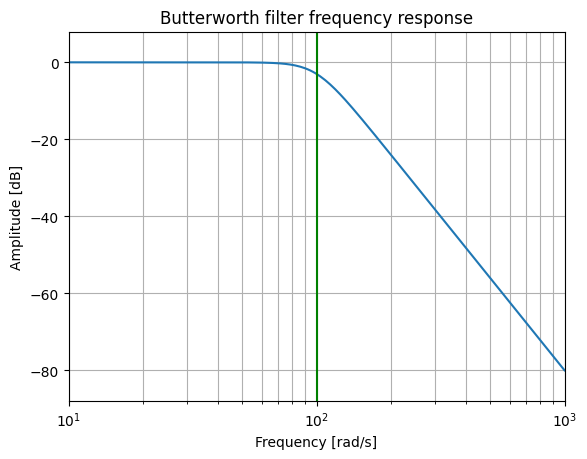

In [60]:
b, a = butter(4, 100, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Do wyznaczenia wartosci kernela filtra buttera, musimy podac maksymalna mozliwa reprezentowalna czestotliwosc, nazywana czestotliwoscia fouriera. Zapewnia ona brak bledow podczas analizowania sygnalu.
- fourier_frequency = max_frequency / 2

In [104]:
def filter_ekg(signal_data, frequency = 128):
    
    
    fourier_frequency = frequency/2
    low_cut = 0.5 #czestotliwosci wolniejsze od 0.5 to najprawdopodniej ruch klatki piersiowej, powodujacy drift 
    high_cut = 40 # w tym przedziale znajduje sie najwiecej zlamkow, wieksze wartosci to w wiekszosci szum

    normalized_low_cut = low_cut/fourier_frequency
    normalized_high_cut = high_cut/fourier_frequency

    b,a = butter(N = 4, Wn=[normalized_low_cut, normalized_high_cut], btype='band')

    filtered_data = filtfilt(b, a, signal_data, axis = 0)

    filtered_frame = pd.DataFrame(filtered_data, columns=signal_data.columns)

    return filtered_frame

clean_df = filter_ekg(resampled_df)

clean_df.head()


,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,8.163490,6.572588,-1.641091,-7.374774,4.955663,2.458511,-3.137310,-6.789411,5.802903,-0.159284,7.984383,5.731224
1,69.004100,71.430828,1.422622,-70.311926,34.300103,35.811302,-441.740423,37.098933,190.850416,166.664741,90.908274,53.376699
2,86.646339,76.652082,-11.219074,-81.698460,49.640171,31.970332,-485.564033,57.068649,227.947710,200.963487,101.568735,70.301061
3,60.893942,43.756026,-17.786145,-52.165471,40.145748,12.061081,-399.535482,65.734884,207.837485,182.761141,93.805469,88.817274
4,30.406218,23.865695,-6.787690,-26.955531,19.438585,7.204125,-419.130894,70.087588,218.601922,195.961667,114.654626,112.901901


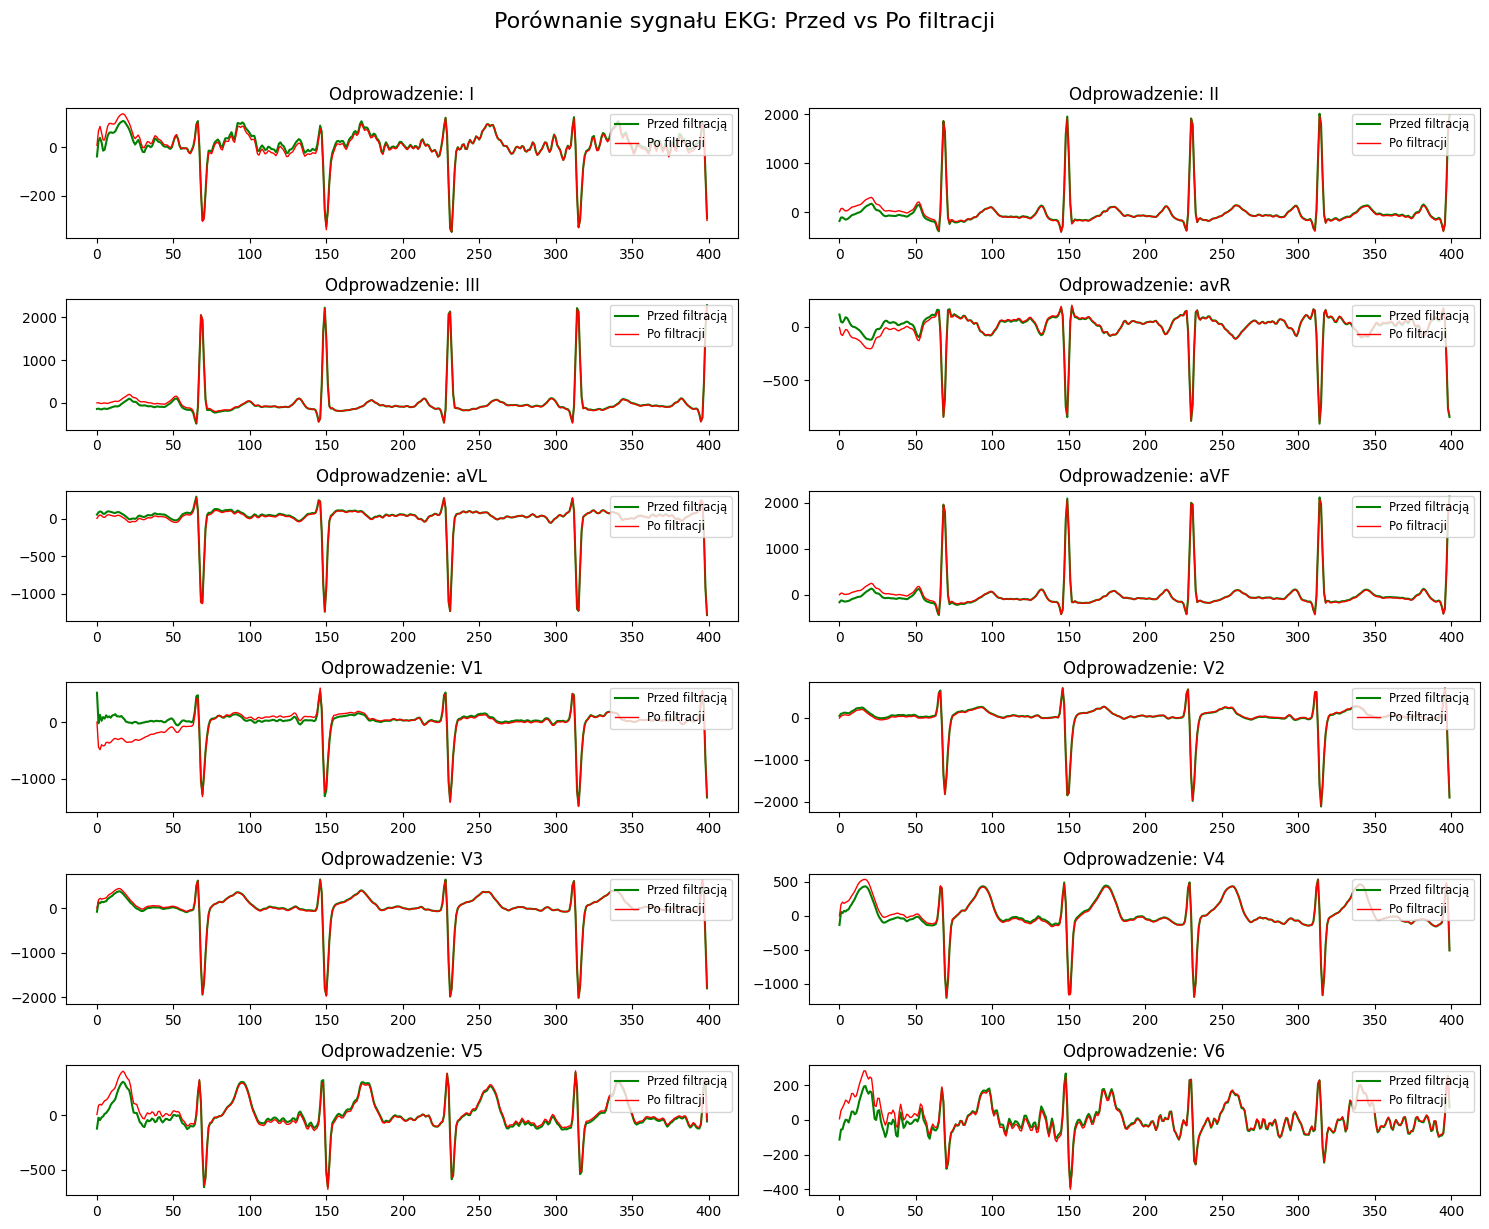

In [62]:
subset_clean = clean_df.iloc[:400]
subset_raw = resampled_df[:400]
import matplotlib.pyplot as plt

columns = subset_clean.columns

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

axes = axes.flatten()



for i, col in enumerate(columns):
    
    subset_raw[col].plot(ax=axes[i], label='Przed filtracją', color='green')
    
    subset_clean[col].plot(ax=axes[i], label='Po filtracji', color='red', linewidth=1)
    
    axes[i].set_title(f"Odprowadzenie: {col}")
    axes[i].legend(loc='upper right', fontsize='small')


plt.suptitle("Porównanie sygnału EKG: Przed vs Po filtracji", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()




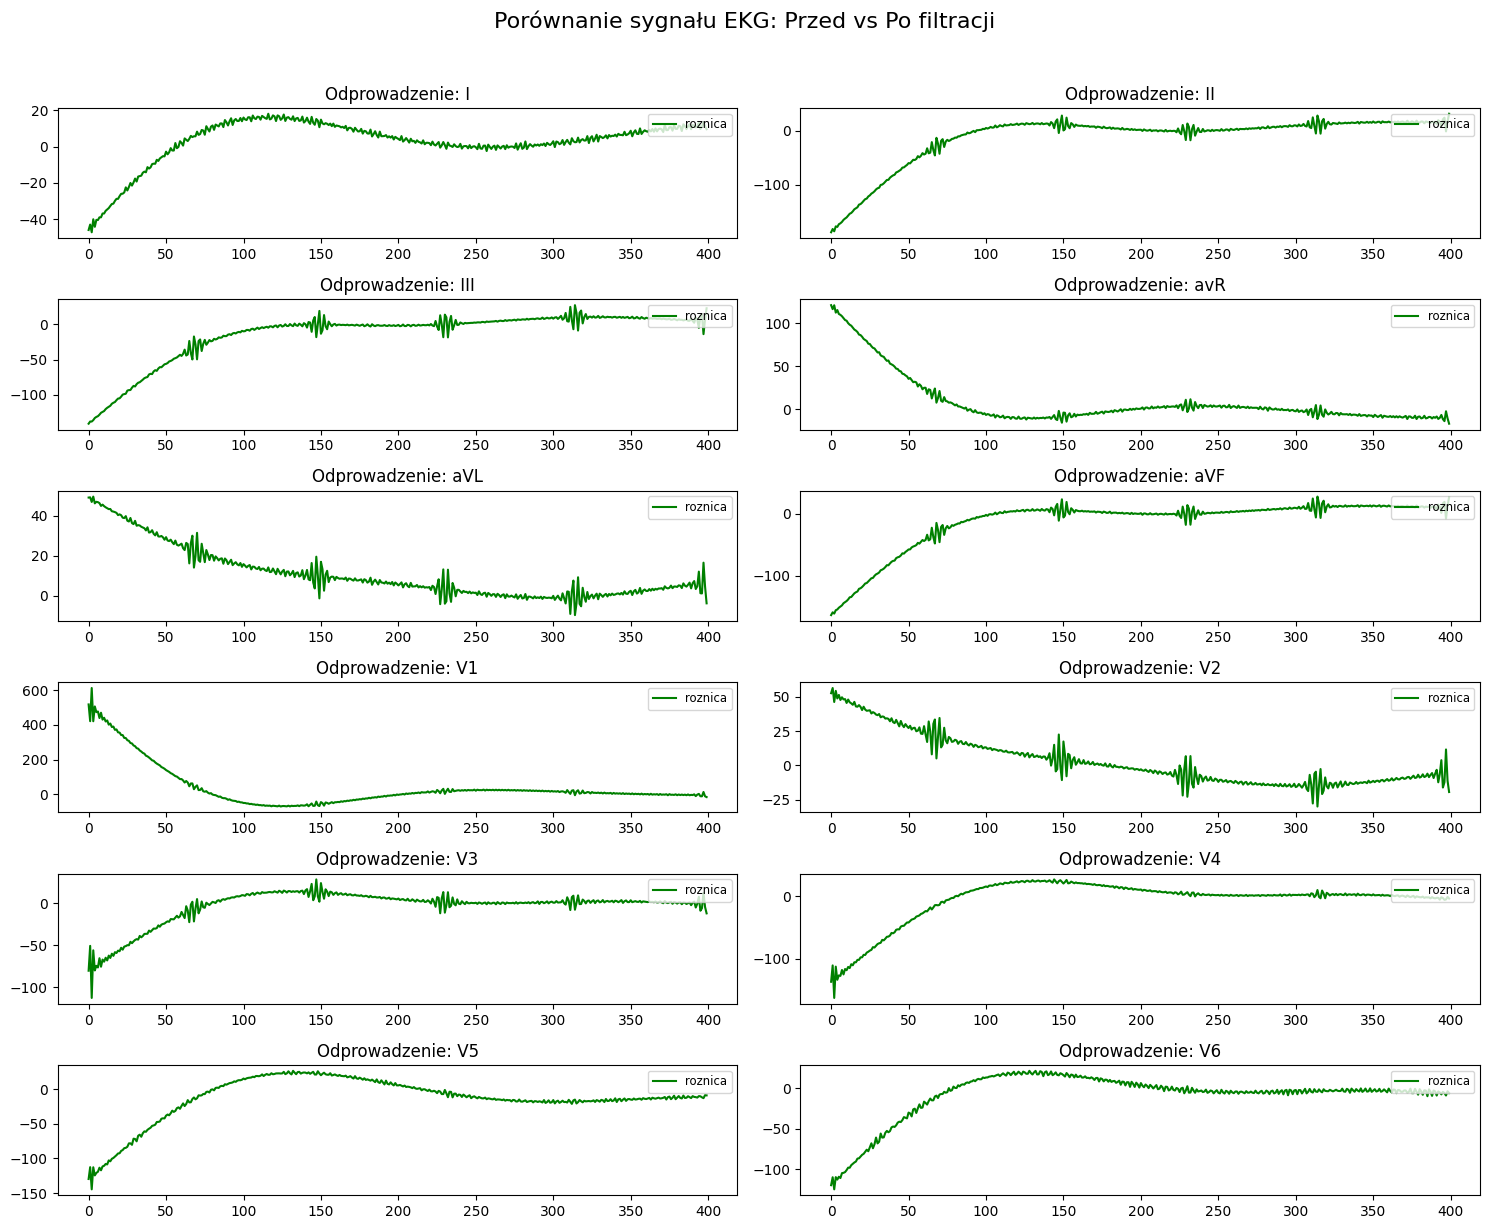

In [63]:
subset_dif =  resampled_df[:400] - subset_clean[:400]


fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

axes = axes.flatten()

columns = subset_clean.columns

for i, col in enumerate(columns):
    
    subset_dif[col].plot(ax=axes[i], color='green', label='roznica')
    
    axes[i].set_title(f"Odprowadzenie: {col}")
    axes[i].legend(loc='upper right', fontsize='small')


plt.suptitle("Porównanie sygnału EKG: Przed vs Po filtracji", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### Podzial sygnalu na okna
5 sekund w pryzpadku wolniejszego bicia serca, moze dac nie wystarczajaca ilosc uderzen do celu analizy.
Przy normalnym biciu serca w 10 sekunach, zmiesci sie do 15 uderzen, ta ilosc bedzie wystarczajaca do analizy.
Przy próbkowaniu 128 Hz daje to: 10×128=1280 próbek w oknie.


In [12]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    
    return X

X_data = create_windows(clean_df, window_seconds=10, step_seconds=5, fs=128)

W celu dokonania analizy outlierow (anomalii w sygnale) sprobujemy dojrzec je wizualizujac dane na boxplotice

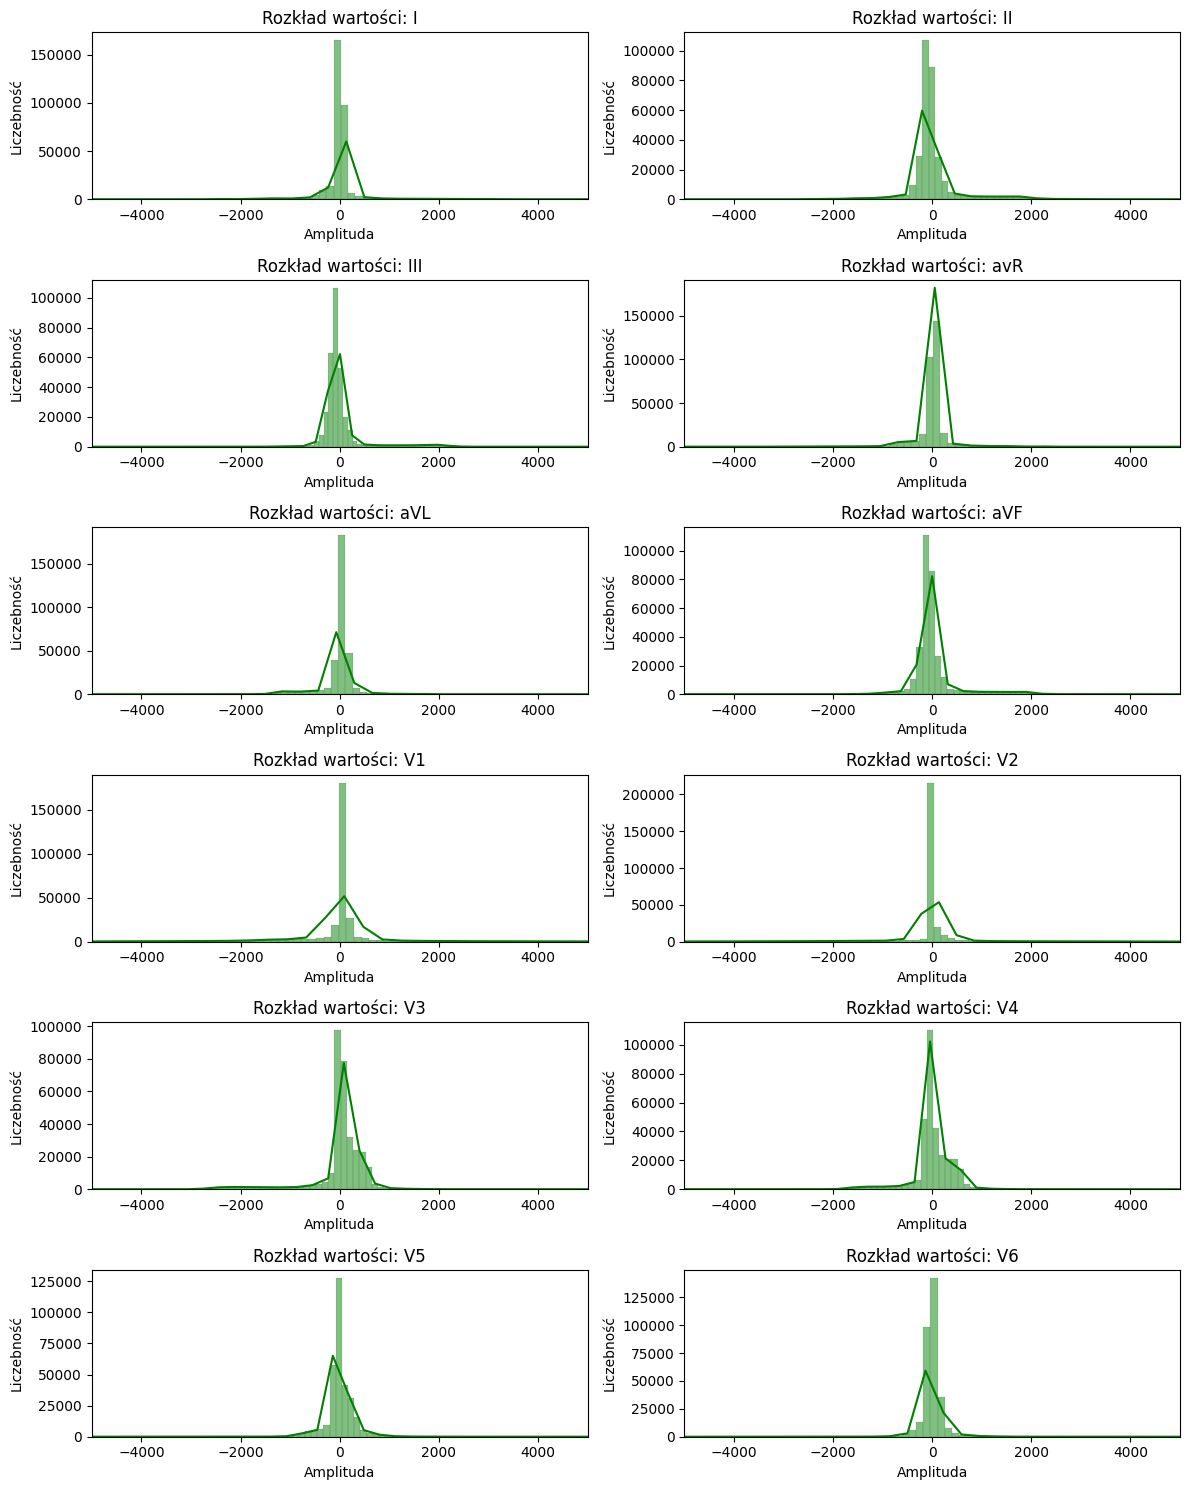

In [16]:
import seaborn as sns

def check_outliers_hist(X_data):

    flattened_data = X_data.reshape(-1, 12) 
    
    
    df_temp = pd.DataFrame(flattened_data, columns=['I','II','III','avR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
    
    figs, axes = plt.subplots(nrows=6, ncols=2, figsize=(12,15))

    axes = axes.flatten()

    columns = df_temp.columns
    for i, col in enumerate(columns):
        sns.histplot(data=df_temp, x=col, ax=axes[i], color='green', kde=True, bins=500)
        

        axes[i].set_xlim(-5000, 5000)
        axes[i].set_title(f"Rozkład wartości: {col}")
        axes[i].set_xlabel("Amplituda")
        axes[i].set_ylabel("Liczebność")
        
    plt.tight_layout()
    plt.show()

X_data = create_windows(clean_df)
check_outliers_hist(X_data)

### Wykrywanie anomalii w oknach
jesli odchylenie standardowe aplitud w oknie wynosi okolo zera, oznacza najprawdopodniej prosta linie, dlatego pomijamy te wartosci
jesli maksymalna wartosc w danym oknie wynosi wiecej niz ustalony treshold, w nasyzm przypadku od 3000 do 5000 oznacza wystapienie anomalii, dlatego pomijamy te wartosci.

Window jest rozmiaru (1200, 12) oznacza to ze mamy 1200 wartosci w kazdym z kanalow


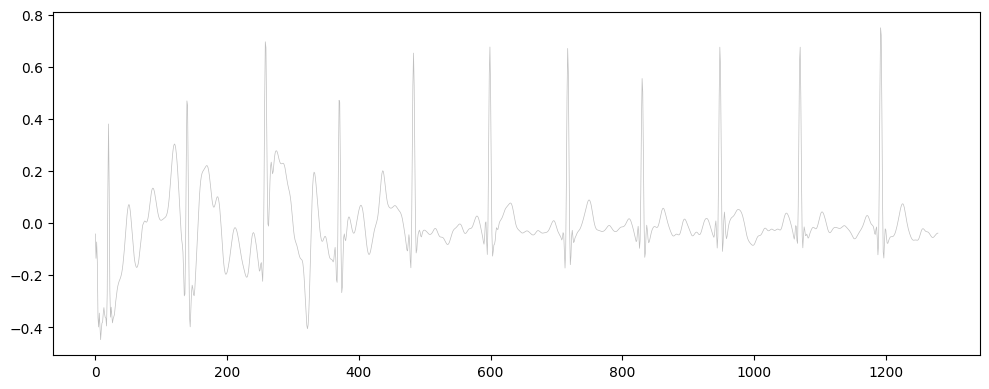

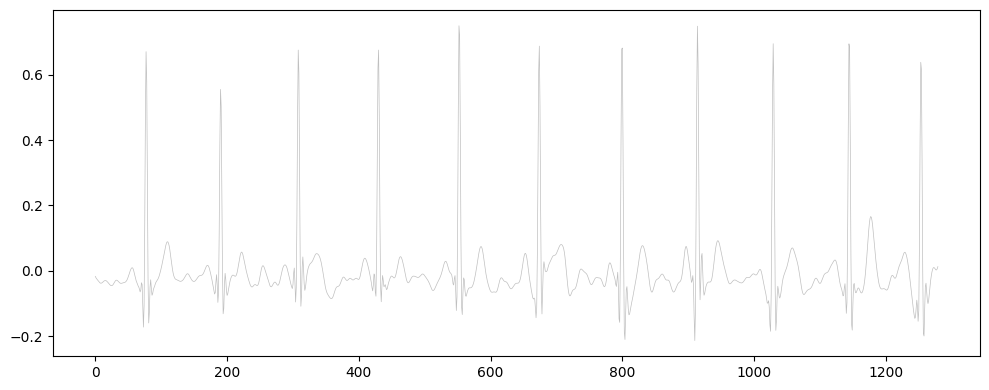

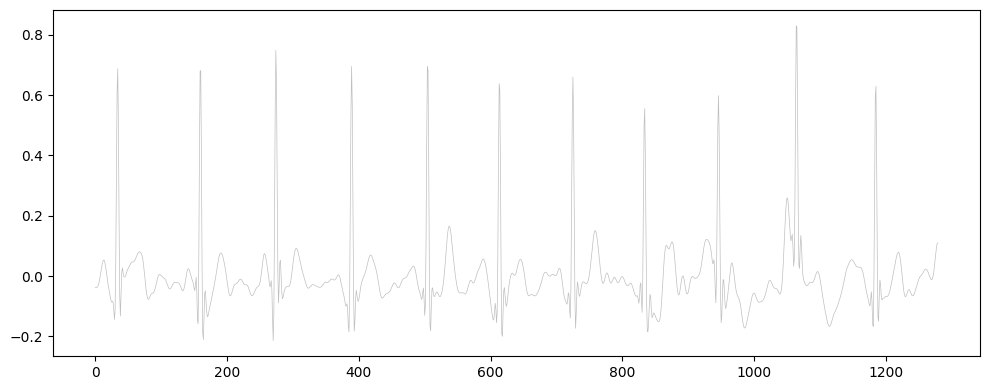

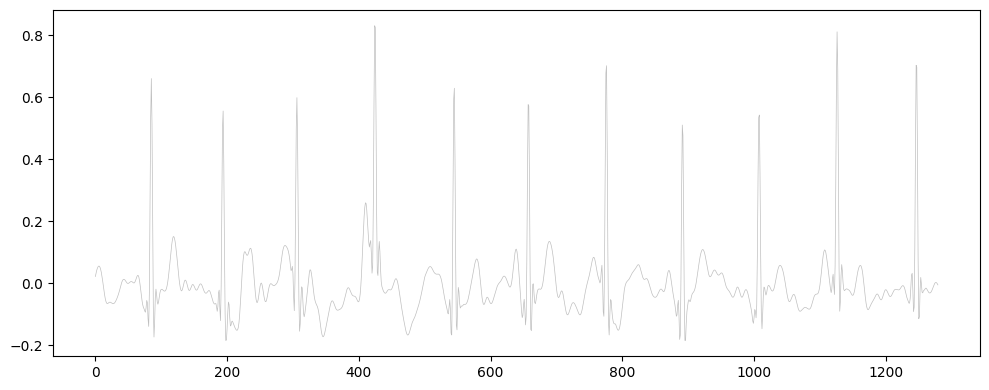

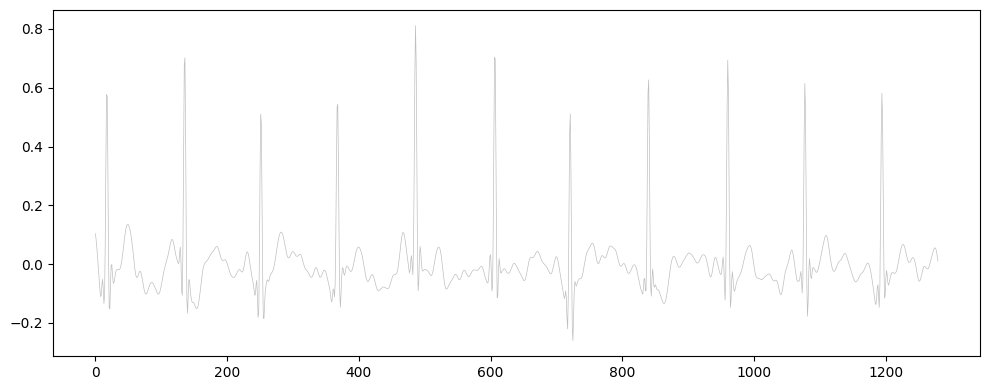

Usunięto 5 okien.
Pozostało 0 dobrych okien.


In [ ]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1000, threshold_min_std=1.0):

    
    good_indices = []
    visualize_count = 0
    
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 12)

        if np.isnan(window).any():
            rejection = True
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
           
            rejection = True
            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            

        window_flattened = window.reshape(-1, 12) 
        diffs = np.diff(window_flattened, axis=0)
        if (np.abs(diffs) > 1500).any():
            rejection = True

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=3000, threshold_min_std=0.5)

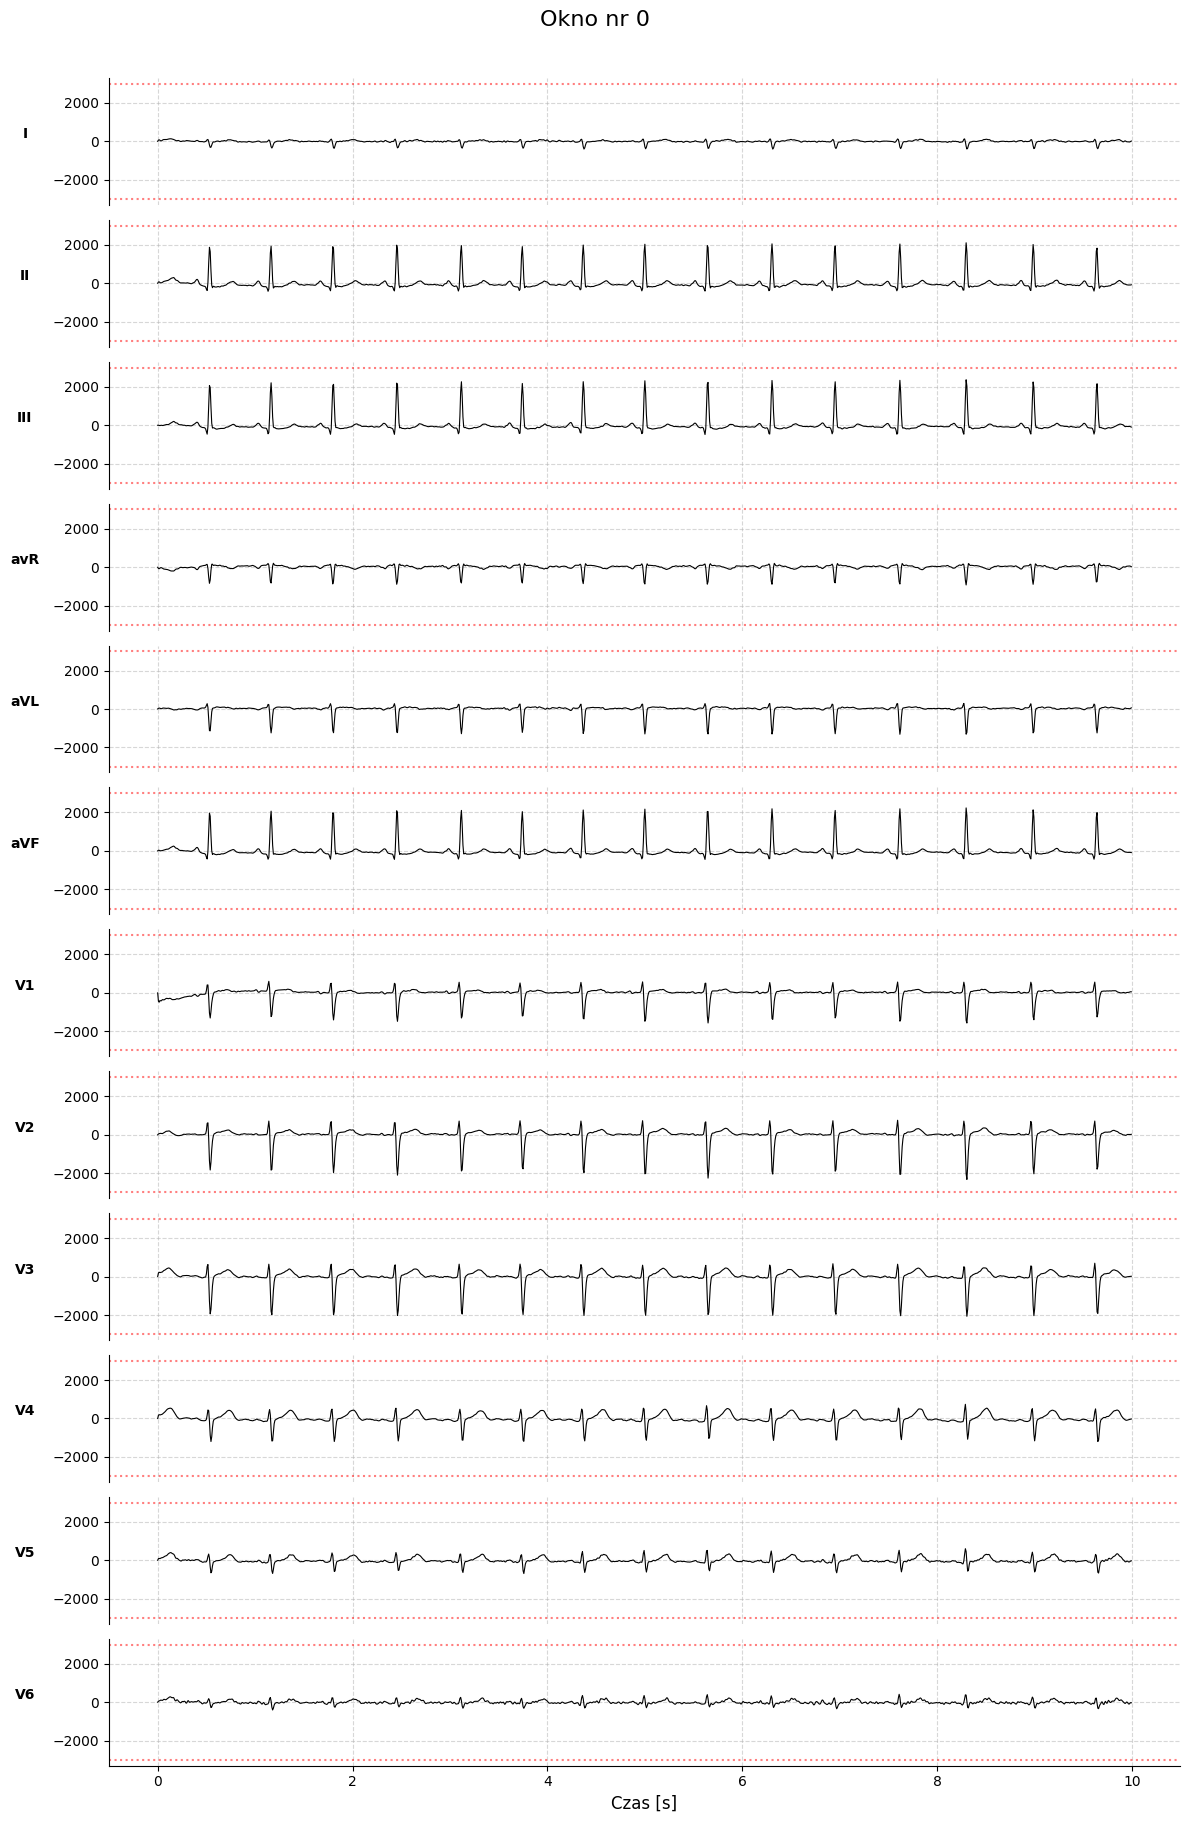

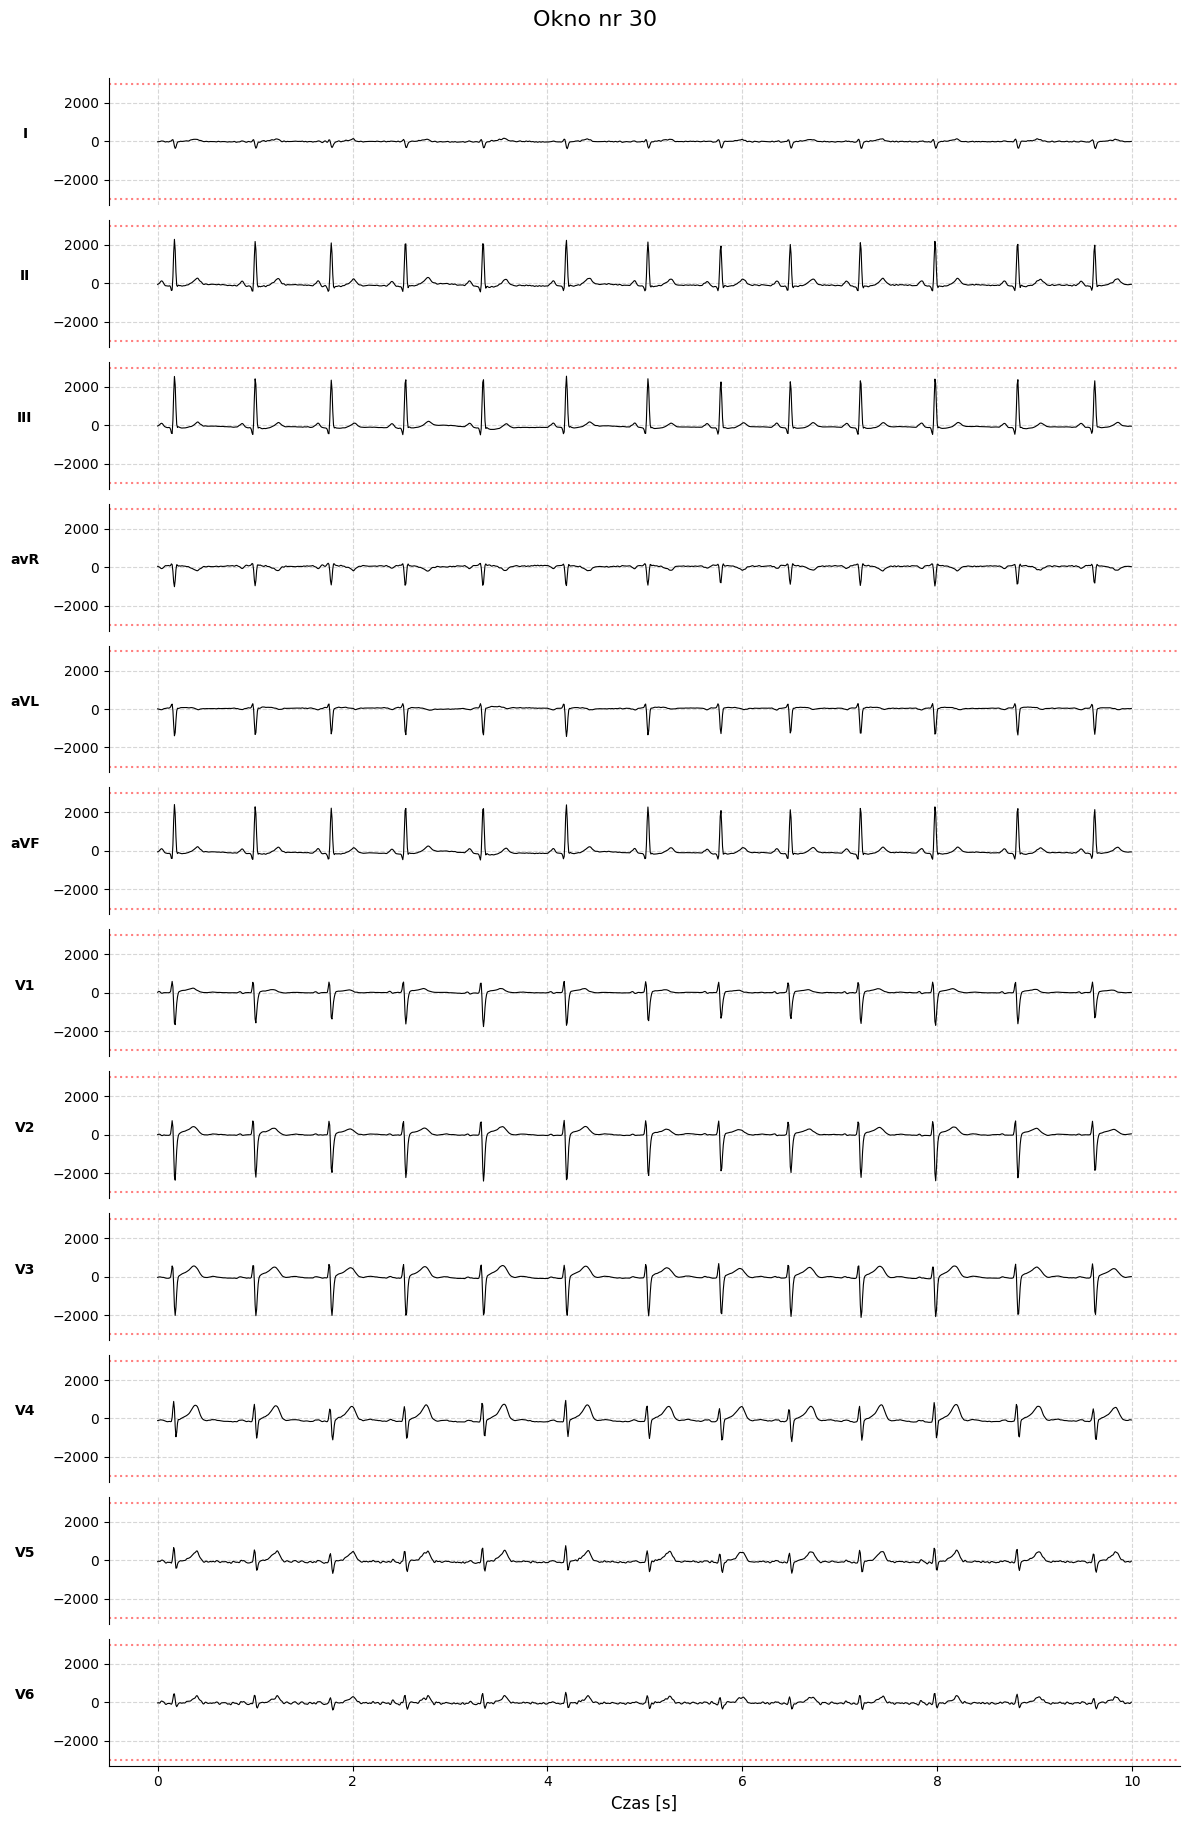

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_window(X_data, window_index, fs=128, threshold=None):
    

    window = X_data[window_index]
    

    time_axis = np.arange(window.shape[0]) / fs
    

    channels = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    

    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 18), sharex=True)
    


    for i in range(12):
        ax = axes[i]
        signal = window[:, i]
        
        ax.plot(time_axis, signal, color='black', linewidth=0.8)
        ax.set_ylabel(channels[i], rotation=0, labelpad=20, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if threshold:
            ax.axhline(y=threshold, color='red', linestyle=':', alpha=0.5)
            ax.axhline(y=-threshold, color='red', linestyle=':', alpha=0.5)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < 11:
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(bottom=False)

    plt.xlabel("Czas [s]", fontsize=12)
    plt.suptitle(f"Okno nr {window_index}", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_window(X_final, window_index=0, fs=128, threshold=3000)

visualize_window(X_final, window_index=30, fs=128, threshold=3000)

In [ ]:

# Zapisujemy przetworzone dane do pliku "pickle" (format pandas zachowujący typy danych) by skorzystać w z3
clean_df.to_pickle("processed_data.pkl")
print("Dane zostały zapisane do pliku 'processed_data.pkl'")

Dane zostały zapisane do pliku 'processed_data.pkl'


### Garmin (zegarek) — przetwarzanie JSON

Poniższe komórki wykonują analogiczne operacje dla danych z zegarka (plik JSON):
- ładowanie surowych próbek z JSON
- wykrycie częstotliwości próbkowania (jeśli dostępne)
- resampling do docelowej częstotliwości (domyślnie 128 Hz)
- filtracja pasmowo-przepustowa (używa `filter_ekg` jeśli jest zdefiniowana)
- dzielenie na okna, wizualizacje i zapis przetworzonych danych

In [46]:
import json
file_path = '/Users/janmichorek/Documents/ProgrammingProjects/HeartAnalisisProject/Projekt-EKG1/Projekt-EKG/data/N36/GARMIN-RECORDINGS/2025-11-14T09-44-17.0_23004d11-0864-4ce7-8a65-fc5b742e4e28.json' 

try:
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        raw_samples = json_data['reading']['samples']
        df_watch = pd.DataFrame(raw_samples, columns=["I"])   
    
    print(f"Wczytano {len(df)} próbek.")

except FileNotFoundError:
    print("Nie znaleziono pliku")



Wczytano 3840 próbek.


In [47]:
#filter watch_df

clean_df_watch = filter_ekg(df_watch)

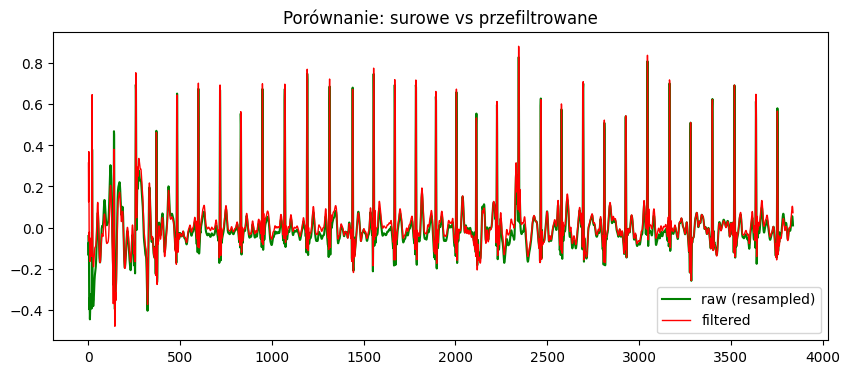

In [48]:
plt.figure(figsize=(10,4))
plt.plot(clean_df_watch, label='raw (resampled)', color='green')
plt.plot(df_watch, label='filtered', color='red', linewidth=1)
plt.title('Porównanie: surowe vs przefiltrowane')
plt.legend()
plt.show()

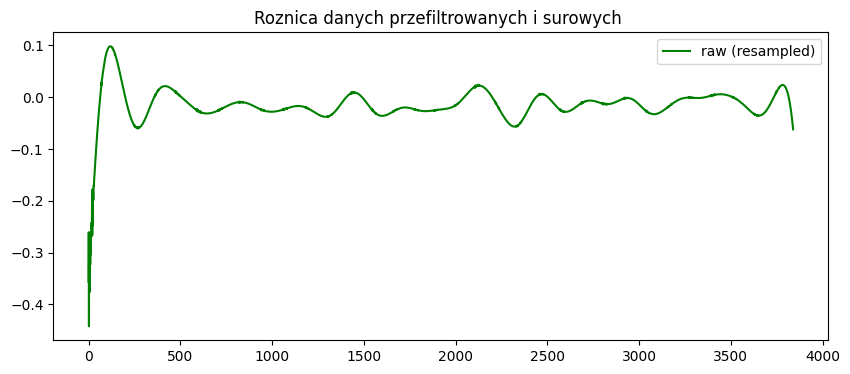

In [49]:
diff_df = clean_df_watch - df_watch

plt.figure(figsize=(10,4))
plt.plot(diff_df, label='raw (resampled)', color='green')
plt.title('Roznica danych przefiltrowanych i surowych ')
plt.legend()
plt.show()

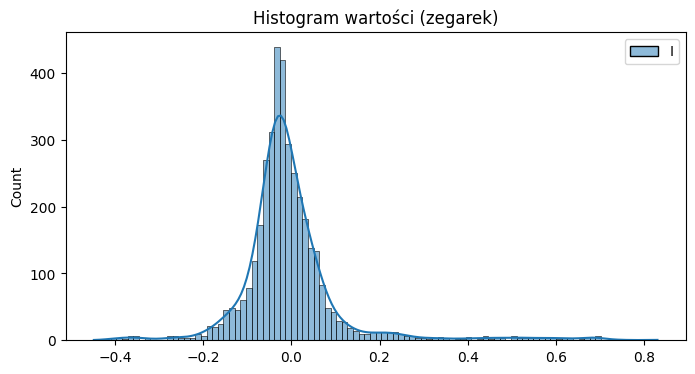

In [51]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(clean_df_watch, bins=100, kde=True, color='blue')
plt.title('Histogram wartości (zegarek)')
plt.show()

In [53]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    print(len(windows))
    
    return X

X_data = create_windows(clean_df_watch, window_seconds=10, step_seconds=5, fs=128)

5


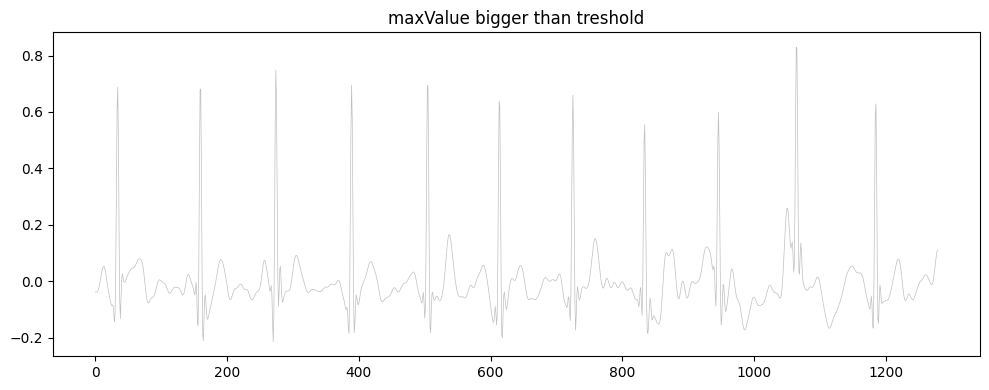

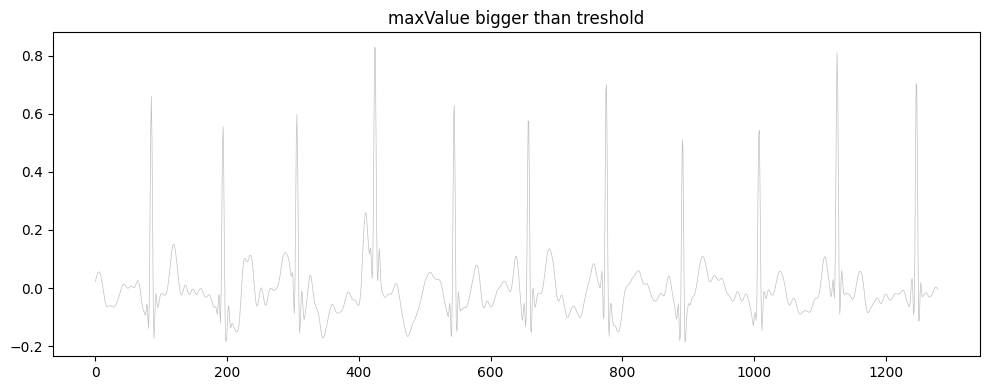

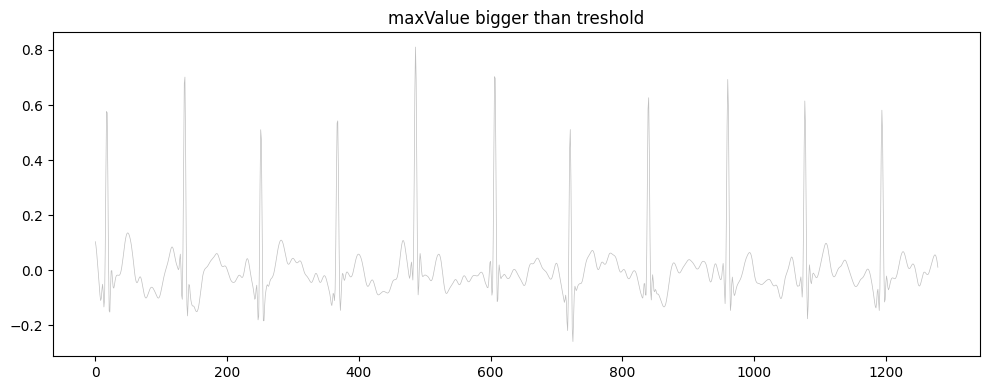

Usunięto 3 okien.
Pozostało 2 dobrych okien.


In [75]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1, threshold_min_std=0.05):

    
    good_indices = []
    visualize_count = 0
    rejection_reason = None
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 1)

        if np.isnan(window).any():
            rejection = True
            rejection_reason = "NanValues"
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
            rejection = True
            rejection_reason = f"too flat (std={stds[0]:.3f})"

            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            rejection_reason = "maxValue bigger than treshold"
            

        
        diffs = np.diff(window, axis=0)
        if (np.abs(diffs) > 1).any():
            rejection = True
            rejection_reason = "too rapid change"

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.title(rejection_reason)
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=0.8, threshold_min_std=0.1)

Text(0.5, 1.0, 'Wizualizacja okna nr 0 (Zegarek)')

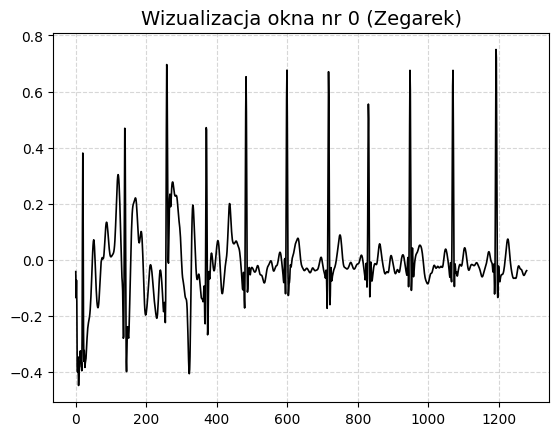

In [86]:
window = X_data[0]
signal = window.flatten()
plt.plot(signal, color='black', linewidth=1.2, label='Sygnał EKG')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title(f"Wizualizacja okna nr 0 (Zegarek)", fontsize=14)





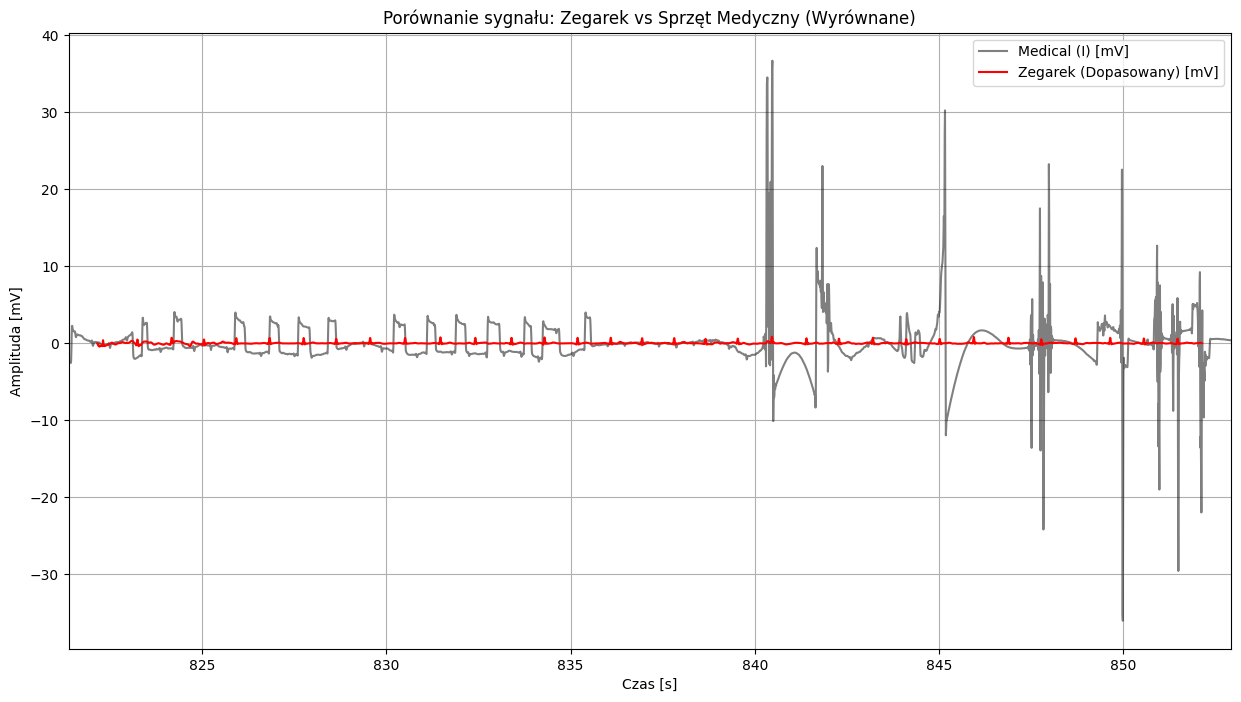

In [103]:
from scipy.signal import correlate

def align_watch_vs_medical(medical_data, watch_data, csv_fs, watch_fs, lead_csv='I'):
    
    sig_long = medical_data[lead_csv].values.flatten()
    
    sig_short = watch_data["I"].values.flatten()

    #zamiana jednostek
    sig_long = sig_long / 1000

    long_centered = sig_long - np.mean(sig_long)
    short_centered = sig_short - np.mean(sig_short)
    
    corr = correlate(long_centered, short_centered, mode='valid')
    best_idx = np.argmax(corr)

    plt.figure(figsize=(15, 8))
    
    t_long = np.arange(len(sig_long)) / 128
    t_short = (np.arange(len(sig_short)) + best_idx) / 128
    
    plt.plot(t_long, sig_long, color='black', alpha=0.5, label=f'Medical ({lead_csv}) [mV]')
    plt.plot(t_short, sig_short, color='red', linewidth=1.5, label='Zegarek (Dopasowany) [mV]')
    
    plt.xlim((best_idx - 100)/128, (best_idx + len(sig_short) + 100)/128)
    
    plt.title("Porównanie sygnału: Zegarek vs Sprzęt Medyczny (Wyrównane)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda [mV]")
    plt.legend()
    plt.grid(True)
    plt.show()



align_watch_vs_medical(clean_df, clean_df_watch, csv_fs=500, watch_fs=128, lead_csv='I')